### 50. データの入手・整形

In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv("newsCorpora.csv", sep="\t", header=None,
                   names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

publishers = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
filtered = data[data["PUBLISHER"].isin(publishers)]

filtered = filtered.sample(frac=1, random_state=42).reset_index(drop=True)

n = len(filtered)
train_end = int(0.8 * n)
valid_end = int(0.9 * n)

train = filtered.iloc[:train_end]
valid = filtered.iloc[train_end:valid_end]
test = filtered.iloc[valid_end:]

def write_dataset(df, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            f.write(f"{row['CATEGORY']}\t{row['TITLE']}\n")

write_dataset(train, "train.txt")
write_dataset(valid, "valid.txt")
write_dataset(test, "test.txt")

print("【タスク50】学習データのカテゴリ分布:")
print(train["CATEGORY"].value_counts())
print("\n【タスク50】評価データのカテゴリ分布:")
print(test["CATEGORY"].value_counts())

    

【タスク50】学習データのカテゴリ分布:
CATEGORY
b    4530
e    4178
t    1225
m     739
Name: count, dtype: int64

【タスク50】評価データのカテゴリ分布:
CATEGORY
b    558
e    541
t    155
m     80
Name: count, dtype: int64


### 51. 特徴量抽出
記事見出しから有用な情報を取り出し、各事例をベクトル表現に変換

In [8]:
import re

def tokenize(text):
    return re.findall(r"\w+", text.lower())

def extract_features(df, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            tokens = tokenize(row["TITLE"])
            f.write(f"{row['CATEGORY']}\t{' '.join(tokens)}\n")

extract_features(train, "train.feature.txt")
extract_features(valid, "valid.feature.txt")
extract_features(test,  "test.feature.txt")

print("【タスク51】特徴量抽出完了。")

【タスク51】特徴量抽出完了。


### 52. 学習

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def load_dataset(filename):
    texts = []
    labels = []
    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) == 2:
                label, text = parts
                labels.append(label)
                texts.append(text)
    return texts, labels

# 学習、検証、評価データの読み込み
train_texts, train_labels = load_dataset("train.txt")
valid_texts, valid_labels = load_dataset("valid.txt")
test_texts,  test_labels  = load_dataset("test.txt")

# 文章を数値ベクトルに変換（Tfidf）
vectorizer = TfidfVectorizer(token_pattern=r"\w+", lowercase=True)
X_train = vectorizer.fit_transform(train_texts)
X_valid = vectorizer.transform(valid_texts)
X_test  = vectorizer.transform(test_texts)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_labels)

print("【タスク52】学習完了。")


【タスク52】学習完了。


### 53. 予測

In [20]:
def predict_headline(headline):
    X = vectorizer.transform([headline])
    proba = clf.predict_proba(X)[0]
    pred_label = clf.predict(X)[0]
    classes = clf.classes_
    result = sorted(zip(classes, proba), key=lambda x: x[1], reverse=True)
    return pred_label, result

example_headline = "Microsoft announces new cloud service" 
pred, probs = predict_headline(example_headline)
print("【タスク53】入力見出し:", example_headline)
print("予測カテゴリ:", pred)
print("各カテゴリの予測確率:")
for label, p in probs:
    print(f"  {label}: {p:.3f}")

【タスク53】入力見出し: Microsoft announces new cloud service
予測カテゴリ: t
各カテゴリの予測確率:
  t: 0.773
  e: 0.118
  b: 0.086
  m: 0.023


### 54. 正解率の計測

In [23]:
from sklearn.metrics import accuracy_score

train_pred = clf.predict(X_train)
train_acc = accuracy_score(train_labels, train_pred)

test_pred = clf.predict(X_test)
test_acc = accuracy_score(test_labels, test_pred)

print("【タスク54】正解率:")
print(f"  学習データ: {train_acc:.3f}")
print(f"  評価データ: {test_acc:.3f}")

【タスク54】正解率:
  学習データ: 0.944
  評価データ: 0.902


### 55. 混同行列の作成
混同行列は各クラスごとに正解と予測の組み合わせを示す表

In [27]:
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(train_labels, train_pred, labels=clf.classes_)
test_cm = confusion_matrix(test_labels, test_pred, labels=clf.classes_)

print("【タスク55】学習データの混同行列:")
print(pd.DataFrame(train_cm, index=clf.classes_, columns=clf.classes_))
print("\n【タスク55】評価データの混同行列:")
print(pd.DataFrame(test_cm, index=clf.classes_, columns=clf.classes_))

【タスク55】学習データの混同行列:
      b     e    m    t
b  4434    59    5   32
e    25  4148    0    5
m    83   122  530    4
t   148   112    1  964

【タスク55】評価データの混同行列:
     b    e   m   t
b  537   16   0   5
e    8  531   1   0
m   16   24  40   0
t   34   25   1  95


### 56. 適合率，再現率，F1スコアの計測
・マイクロ平均：全体の正例と負例の合計から計算  
・マクロ平均：各クラスごとの平均

In [37]:
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score

# 各カテゴリごとのスコア計算
precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_pred, labels=clf.classes_)
results = pd.DataFrame({
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "Support": support
}, index=clf.classes_)
print("【タスク56】各カテゴリの評価指標:")
print(results)

# マイクロ平均
precision_micro = precision_score(test_labels, test_pred, average="micro")
recall_micro = recall_score(test_labels, test_pred, average="micro")
f1_micro = f1_score(test_labels, test_pred, average="micro")
# マクロ平均
precision_macro = precision_score(test_labels, test_pred, average="macro")
recall_macro = recall_score(test_labels, test_pred, average="macro")
f1_macro = f1_score(test_labels, test_pred, average="macro")

print("\n【タスク56】マイクロ平均:")
print(f"  Precision: {precision_micro:.3f}, Recall: {recall_micro:.3f}, F1: {f1_micro:.3f}")
print("【タスク56】マクロ平均:")
print(f"  Precision: {precision_macro:.3f}, Recall: {recall_macro:.3f}, F1: {f1_macro:.3f}")


【タスク56】各カテゴリの評価指標:
   Precision    Recall        F1  Support
b   0.902521  0.962366  0.931483      558
e   0.889447  0.983333  0.934037      540
m   0.952381  0.500000  0.655738       80
t   0.950000  0.612903  0.745098      155

【タスク56】マイクロ平均:
  Precision: 0.902, Recall: 0.902, F1: 0.902
【タスク56】マクロ平均:
  Precision: 0.739, Recall: 0.612, F1: 0.653


/opt/anaconda3/envs/torch_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 57. 特徴量の重みの確認

In [44]:
feature_names = vectorizer.get_feature_names_out()

for i, class_label in enumerate(clf.classes_):
    coef = clf.coef_[i]
    top10_idx = coef.argsort()[-10:][::-1]
    bottom10_idx = coef.argsort()[:10]
    print(f"【タスク57】クラス: {class_label}")
    print("  トップ10（正の重み）:")
    for idx in top10_idx:
        print(f"    {feature_names[idx]}: {coef[idx]:.4f}")
    print("  トップ10（負の重み）:")
    for idx in bottom10_idx:
        print(f"    {feature_names[idx]}: {coef[idx]:.4f}")
    print()

【タスク57】クラス: b
  トップ10（正の重み）:
    china: 3.4610
    bank: 3.4292
    fed: 3.4243
    stocks: 3.0661
    ecb: 2.9338
    euro: 2.8756
    ukraine: 2.5680
    oil: 2.5429
    dollar: 2.5422
    yellen: 2.4813
  トップ10（負の重み）:
    and: -2.2789
    ebola: -2.0521
    the: -1.9429
    her: -1.9015
    apple: -1.8629
    she: -1.8101
    google: -1.6505
    facebook: -1.6260
    kardashian: -1.5964
    star: -1.5844

【タスク57】クラス: e
  トップ10（正の重み）:
    kardashian: 3.2855
    chris: 2.7500
    her: 2.6573
    she: 2.5227
    star: 2.5133
    miley: 2.4906
    kim: 2.4790
    cyrus: 2.4323
    movie: 2.2690
    paul: 2.1738
  トップ10（負の重み）:
    us: -3.1656
    google: -2.9445
    update: -2.5192
    ceo: -2.3270
    china: -2.2952
    facebook: -2.2118
    1: -2.2098
    says: -2.2039
    gm: -2.1453
    apple: -2.0779

【タスク57】クラス: m
  トップ10（正の重み）:
    ebola: 4.6027
    study: 3.9290
    cancer: 3.6594
    fda: 3.5322
    drug: 3.4561
    mers: 3.2074
    health: 2.8209
    cases: 2.3681
    e: 2.2965

### 58. 正則化パラメータの変更

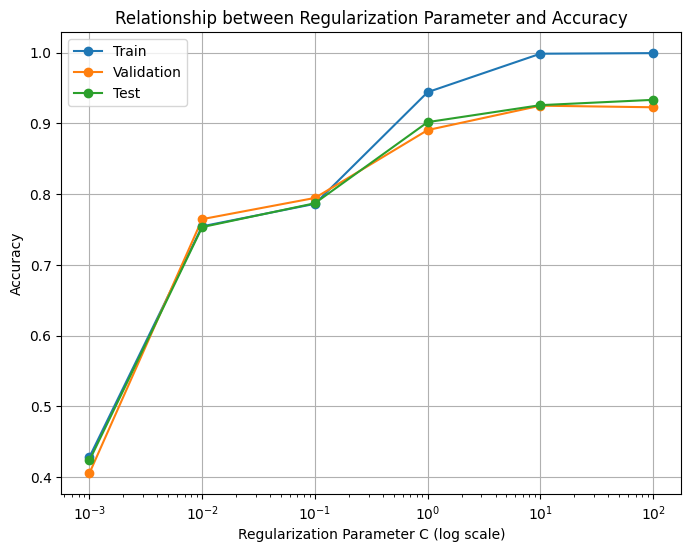

In [61]:
import matplotlib.pyplot as plt

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
train_accs = []
valid_accs = []
test_accs  = []

for C in C_values:
    clf_temp = LogisticRegression(C=C, max_iter=1000)
    clf_temp.fit(X_train, train_labels)
    train_accs.append(clf_temp.score(X_train, train_labels))
    valid_accs.append(clf_temp.score(X_valid, valid_labels))
    test_accs.append(clf_temp.score(X_test, test_labels))

plt.figure(figsize=(8, 6))
plt.plot(C_values, train_accs, marker='o', label="Train")
plt.plot(C_values, valid_accs, marker='o', label="Validation")
plt.plot(C_values, test_accs, marker='o', label="Test")
plt.xscale("log")
plt.xlabel("Regularization Parameter C (log scale)")
plt.ylabel("Accuracy")
plt.title("Relationship between Regularization Parameter and Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### 59. ハイパーパラメータの探索

In [69]:
from sklearn.naive_bayes import MultinomialNB

best_model = None
best_score = 0
best_params = None

# ロジスティック回帰の場合
print("【タスク59】ハイパーパラメータ探索（ロジスティック回帰）")
for C in [0.01, 0.1, 1, 10, 100]:
    clf_temp = LogisticRegression(C=C, max_iter=1000)
    clf_temp.fit(X_train, train_labels)
    score = clf_temp.score(X_valid, valid_labels)
    print(f"  LogisticRegression C={C}, 検証正解率: {score:.3f}")
    if score > best_score:
        best_score = score
        best_model = ("LogisticRegression", C, clf_temp)
        best_params = {"algorithm": "LogisticRegression", "C": C}

# MultinomialNB の場合
print("\n【タスク59】ハイパーパラメータ探索（MultinomialNB）")
for alpha in [0.001, 0.01, 0.1, 0.5]:
    clf_temp = MultinomialNB(alpha=alpha)
    clf_temp.fit(X_train, train_labels)
    score = clf_temp.score(X_valid, valid_labels)
    print(f"  MultinomialNB alpha={alpha}, 検証正解率: {score:.3f}")
    if score > best_score:
        best_score = score
        best_model = ("MultinomialNB", alpha, clf_temp)
        best_params = {"algorithm": "MultinomialNB", "alpha": alpha}

print("\n【タスク59】最適なモデル:")
print(best_params)
# 最適モデルを評価データで評価
if best_params["algorithm"] == "LogisticRegression":
    test_accuracy = best_model[2].score(X_test, test_labels)
else:
    test_accuracy = best_model[2].score(X_test, test_labels)
print(f"評価データでの正解率: {test_accuracy:.3f}")

【タスク59】ハイパーパラメータ探索（ロジスティック回帰）
  LogisticRegression C=0.01, 検証正解率: 0.765
  LogisticRegression C=0.1, 検証正解率: 0.795
  LogisticRegression C=1, 検証正解率: 0.891
  LogisticRegression C=10, 検証正解率: 0.925
  LogisticRegression C=100, 検証正解率: 0.923

【タスク59】ハイパーパラメータ探索（MultinomialNB）
  MultinomialNB alpha=0.001, 検証正解率: 0.920
  MultinomialNB alpha=0.01, 検証正解率: 0.922
  MultinomialNB alpha=0.1, 検証正解率: 0.918
  MultinomialNB alpha=0.5, 検証正解率: 0.878

【タスク59】最適なモデル:
{'algorithm': 'LogisticRegression', 'C': 10}
評価データでの正解率: 0.926
